In [1]:
import block_methods as BM

from Lanczos_FA.lanczos_bin import *

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import integrate
plt.rcParams["figure.figsize"] = (16,9)

In [2]:
n = 1000 # matrix dimension
b = 2 # block size
K = 200 # max iter

# set up matrix
lam = np.linspace(1e-2,1,n)
H = np.diag(lam)

# set up vector
V = np.random.randn(n,b)

# w value
w = 0

# how many iterations oer sample for plotting
step = 5

# define contour
def Gamma(t):
    radius = lmax_ - lmin_/100

    z = radius*np.exp(1j*t)+lmax_
    dz = radius*1j*np.exp(1j*t)
    
    return z,dz

# define function
def f(x):
    return np.sqrt(x)

In [3]:
Q,Qkp1,A,B,B_0 = BM.block_lanczos(H, V, K, K+1)

# generate tridiagonal matrix and get eigendecomp
T = BM.get_block_tridiag(A,B)
EvalT, EvecT = np.linalg.eigh(T)

In [4]:
lmin = np.min(lam).astype(np.double)
lmax = np.max(lam).astype(np.double)
kappa = lmax / lmin

lmin_ = lmin/2
lmax_ = 2*lmax

In [5]:
def Q_wz(w,z,lmin,lmax):
    """
    max_{x\in[lmin,lmax]} |x-w|/|z-w|
    """
    
    if np.real(z) - w != 0:
        b_hat = ( np.abs(z)**2 - np.real(z)*w ) / (np.real(z) - w)
    else:
        b_hat = np.inf
    
    if lmin < b_hat <= lmax:
        return np.abs((z-w)/np.imag(z))
    else:
        return np.max([np.abs((lmax-w)/(lmax-z)), np.abs((lmin-w)/(lmin-z))])

In [6]:
def block_a_posteriori_bound(T, f,gamma,endpts,w,lmin,lmax, k, B_0):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
    Eval, Evec = np.linalg.eigh(T)
    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.abs(f(z)) * np.linalg.norm(BM.get_CwinvCz(Eval,Evec,z,w,np.shape(B_0)[0],B_0)) * Q_wz(w,z,lmin,lmax) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200) 
    
    return integral

In [7]:
def block_a_posteriori_bound_mid(T, f, gamma, endpts, Q, H, V, B_0):
    """
    (1/2pi) \oint_{\Gamma} |f(z)| |D_{k,w,z}| Q_{w,z} |dz|
    """
    
    Eval, Evec = np.linalg.eigh(T)
    def F(t):
        z,dz = gamma(t)
        
        return (1/(2*np.pi)) * np.linalg.norm(f(z)* exact_err(z, H, V, Q, T, B_0)) * np.abs(dz)
    
    integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200)
    
    return integral

In [8]:
def block_a_posteriori_bound_exact(T, f, H, V, Q, B_0, bsize):
    EvalH, EvecH = np.linalg.eigh(H)
    fEvalH = f(EvalH)
    fH = EvecH@np.diag(fEvalH)@EvecH.conj().T
    
    EvalT, EvecT = np.linalg.eigh(T)
#     EvalT may be negative, and np.sqrt only let imaginary output when input is complex
#     thus, we make first element of EvalT complex first. 
    EvalT = EvalT.astype(complex)
    EvalT[0] = EvalT[0]+0j
    
    fEvalT = f(EvalT)
    fT = EvecT@np.diag(fEvalT)@EvecT.conj().T
    
#     changed the line below, was:
#   return np.linalg.norm(fH@V-(Q@fT)[:, 0]@B_0)
#   reason: should keep the first column of block, as opposed to first col.
    return np.linalg.norm(np.reshape(fH@V, (n, bsize)).T-((Q@fT)[:, :bsize]@B_0).T)

In [9]:
# use linear solver as oppose to get inverse
def exact_err(z, H, V, Q, T, B_0):
    Hinv = 1/(np.diag(H)-z)
#     HinvV2 = Hinv*V
    
#     NOTE: apparently this implementation further tanks performance as its nolonger "vectorized".
#     Below is the new way of computing HinvV for better compatibility with block size larger than 1.
#     Above commented out was the old code that only works with block size 1
#     this if statement checks if V is 1d, aka block size = 1. If true, reshape to 2D format for compatibility
    if (np.shape(np.shape(V))[0] == 1): 
        V = np.reshape(V, (len(V), 1))
        
    HinvV = np.zeros(np.shape(V),dtype = 'complex_')
    for i in np.arange(np.shape(V)[1]):
        HinvV[:, i] = Hinv*V[:, i]
    
#     due to mismatched shape, we do transpose
    HinvV = HinvV.T
    
#     print(np.linalg.norm(HinvV-HinvV2))

    E1 = BM.Ei(np.shape(T)[0], np.shape(B_0)[0], 1)
#     E1_array = np.reshape(E1, len(E1))
    TinvE = np.linalg.solve((T-z*np.eye(T.shape[0])), E1)
#     This line below is changed
    return HinvV.T - Q@TinvE@B_0

In [10]:
block_mid = np.full(K,np.inf)
block_exact = np.full(K,np.inf)
block_bound = np.full(K,np.inf)

for k in range(1,int((K+1)/step)):
    k = step*k
#     unit is the number of rows/cols of Q and T to pass to the bound-finding-methods.
    unit = k*b
    block_mid[int((k-1)/step)] = block_a_posteriori_bound_mid(T[:unit, :unit], f,Gamma,[0,np.pi], Q[:, :unit], H, V.astype(np.double), B_0)[0]
    block_exact[int((k-1)/step)] = block_a_posteriori_bound_exact(T[:unit, :unit], f,H.astype(np.double), V.astype(np.double),Q[:, :unit], B_0, b)
    block_bound[int((k-1)/step)] = block_a_posteriori_bound(T[:unit, :unit], f,Gamma,[0,np.pi],w,lmin_,lmax_, k, B_0)[0]

C:\Users\qcx\AppData\Local\Temp\ipykernel_7388\1825504721.py:11: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = sp.integrate.quad(F,endpts[0],endpts[1],epsabs=0,limit=200)
C:\Users\qcx\AppData\Local\Temp\ipykernel_7388\4243481732.py:12: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting

In [11]:
np.shape(T)[0]

400

In [12]:
np.shape(B_0)[0]

2

In [13]:
3000/20

150.0

In [14]:
full_block_bound = np.full(K,np.inf)

for k in range(1,int((K+1)/step)):
    k = step*k
    full_block_bound[int((k-1)/step)] = block_bound[int((k-1)/step)]*np.linalg.norm(exact_err(w, H, V, Q[:, :k], T[:k, :k], B_0))

<function matplotlib.pyplot.show(close=None, block=None)>

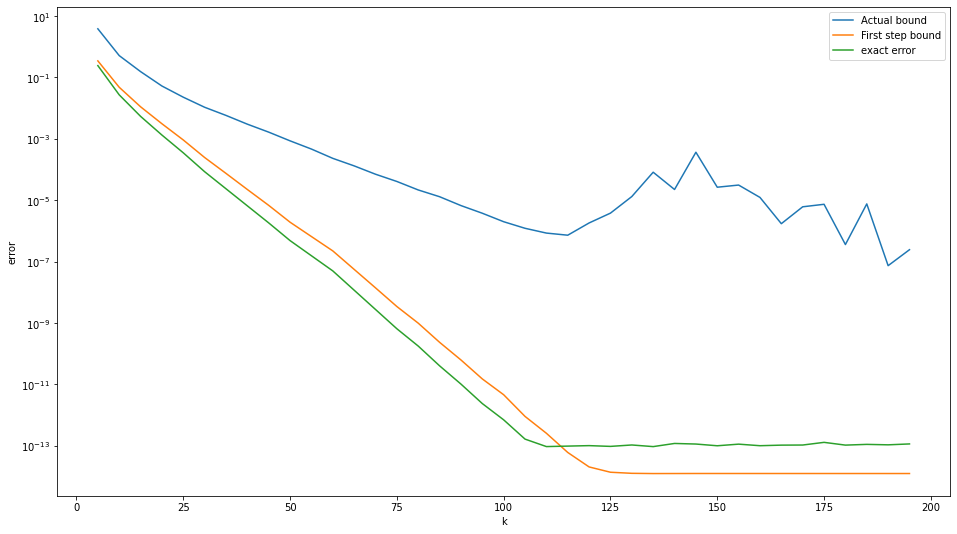

In [15]:
x = np.linspace(1, K, K)

plt.plot(x*step, np.abs(full_block_bound), label = "Actual bound")
plt.plot(x*step, np.abs(block_mid), label = "First step bound")
plt.plot(x*step, np.abs(block_exact), label = "exact error")


plt.yscale('log')
plt.xlabel("k")
plt.ylabel("error")
plt.legend()
plt.show